# This notebook reproduces the plots presented in Chapter 9 of my thesis. 

In [2]:
using LinearAlgebra
using FFTW
using PyPlot
using Statistics
using Interpolations
using Random, Distributions
using JLD
using DSP

# Import parameters

In [3]:
# simulation parameters
include("params/params.jl");


standard parameters (non dimensional)
Hbar, Qbar, Γ, γ, Abar, Δa, Sref 

--- 
dimensionalization constants
Dₐ(km), Tₐ(h), Θₐ(Kelvin), Uₐ(m/s)  

--- 
simulation specific parameters

YEARS, DAYS

L, Nx, dx, Δt, tlength (total simulation time in days), T (total simulation time dimensionless), Nt;
κ (domain frequencies)

dostocha (stochastic switch)
num_rep (repetitions to reach equilibrium)
background_type (homogeneous, warmpool, climatology, El Niño, La Niña)

smoothing parameters for the background type
num_k, alpha

---
all possible background profiles are included (CHANGE LATER TO ONLY THE NECESSARY ONES)

longitudes (longitudinal points)
ref_Stheta, ref_Sq, ref_HbarA (forcing profiles for climatology)
ElNino_Stheta, ElNino_Sq, ElNino_HbarA (forcing profiles for El Nino)
LaNina_Stheta, LaNina_Sq, LaNina_HbarA (forcing profiles for La Nina)

---
finally chosen background profiles

Stheta, Sq, Aₛ

satisfying 
̄HAₛ=(Sq-̄Q*Stheta)/(1-Q) 


In [4]:
println("Forcing period: ", d1_y, " - ", d2_y)

Forcing period: 1979 - 2021


# Load data 

In [5]:
data_folder = "data/"

"data/"

In [6]:
# load and extract simulation variables
variables = load("./data/variables.jld")

u_daily = variables["u_daily"]; #dims (longitude, number of independant simulation runs, simulation day)
u_daily_filtered = variables["u_daily_filtered"];
ha_daily = variables["ha_daily"];
ha_daily_filtered = variables["ha_daily_filtered"];

NUM_REPEAT = size(u_daily)[2]; # number of independant simulation runs
Nd = size(ha_daily)[3]; # number of simulation days

# identify the date that goes with each element of the time array
month_idx = floor.(Int, months_fine);
month_array = [dates_tmp[i+1].month for i in month_idx];
year_array = [dates_tmp[i+1].year for i in month_idx];

# find the last 43 years
itk = length(year_array);
while(year_array[itk]>1979)
    itk=itk-1;
end
while(year_array[itk]==1979)
    itk=itk-1;
end
itk = itk+1;

times_ = range(Δt, step = Δt, length = Nt)
times = times_[itk:end];


sim_day = floor.(times*Tₐ/24)
months_tracked_ = zeros(length(unique(sim_day))) # for each simulation day we need to know to which month it corresponds
years_tracked = zeros(length(unique(sim_day))) # and to which year
i=1
for d in unique(sim_day)
    idxs = findall(sim_day .== d);
    months_tracked_[i] = mean(month_array[itk:end][idxs]); 
    years_tracked[i] = mean(year_array[itk:end][idxs]);
    i+=1;
end
sim_day = unique(sim_day);

# Useful fonctions

In [7]:
include("functions/smm.jl");
include("functions/events_characteristics.jl");

parameters

# Plot forcing profiles

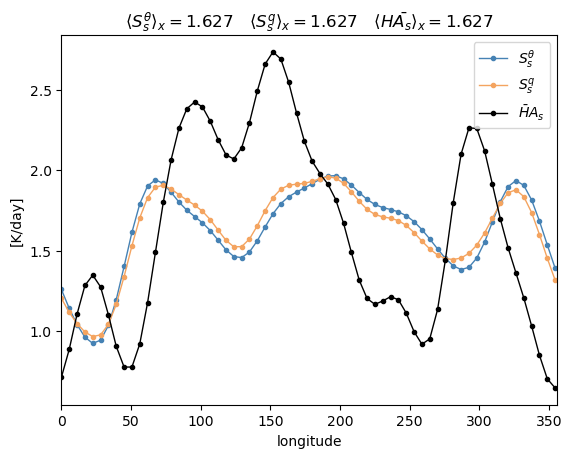

In [8]:
# plot the temporal mean of the forcing profiles in dimentional units
plot(longitudes, mean_Stheta[1,:].*15.0*24.0/Tₐ, "-o", linewidth = 1, markersize =3, color = "steelblue", label = L"$S^\theta_s$");
plot(longitudes, mean_Sq[1,:].*15.0*24.0/Tₐ, "-o", linewidth = 1, markersize =3, color = "sandybrown", label = L"$S^q_s$");
plot(longitudes, Hbar*mean_Aₛ[1,:].*15.0*24.0/Tₐ, "-o", linewidth = 1, markersize =3, color = "black", label = L"$\bar{H}A_s$");
legend()
ylabel("[K/day]")
xlabel("longitude")
xlim([0,356]);


# print the spatial and temporal mean of the forcing profiles (they should be equal)
st_mean_Stheta= round(mean(mean_Stheta[1,:]).*15.0*24.0/Tₐ,digits=4);
st_mean_Sq = round(mean(mean_Sq[1,:])*15.0*24.0/Tₐ,digits=4);
st_mean_Ha = round(mean(Hbar*mean_Aₛ[1,:])*15.0*24.0/Tₐ,digits=4);

mean_vals = L"\langle S^\theta_s \rangle_x = %$(st_mean_Stheta) \quad \langle S^q_s \rangle_x = %$(st_mean_Sq) \quad \langle H \bar{A_s} \rangle_x = %$(st_mean_Ha)";
title(mean_vals);


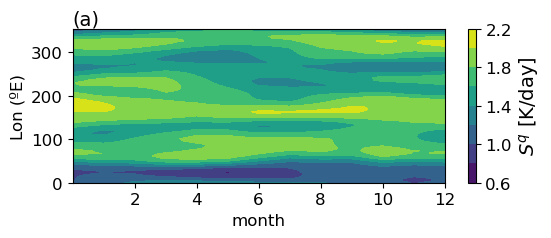

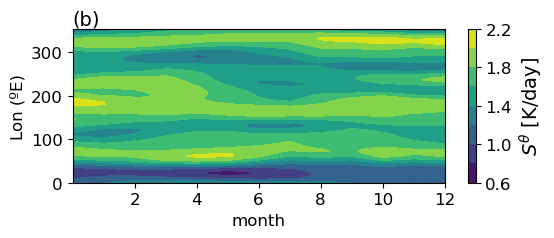

In [9]:
function plot_first_year(months_fine, S, cbar_label, plot_label, save_name)
    # profiles are saved in an array (time, space) with Δt = 1.7 hours 
    # find the indices (along the first axis) that belong to the first year of simulation
    idx_first_year = findall(x -> x < 12, floor.(Int, months_fine))
    time_ = months_fine[idx_first_year]

    # Spatial discretization 
    space_ = range(0, stop = 360 - 360 / 64.0, length = 64)
    
    # Mesh
    X = repeat(reshape(space_, 1, :), length(time_))
    Y = repeat(time_, 1, length(space_))

    # Plotting
    fig, ax = subplots(1, 1, figsize = (6, 2))
    im1 = ax.contourf(Y', X', 15.0 * 24.0 / Tₐ .* S[idx_first_year, :]') # dimensionalize Sq for plotting

    # Colorbar and labels
    cbar1 = colorbar(im1)
    cbar1.set_label(cbar_label, fontsize = 14)

    ax.set_xlabel("month", fontsize = 12)
    ax.set_ylabel("Lon (ºE)", fontsize = 12)
    ax.text(0, 365, plot_label, fontsize = 14)
    ax.tick_params(axis = "both", which = "major", labelsize = 12)

    # Customize colorbar ticks
    cbar1.ax.locator_params(nbins = 5)
    cbar1.ax.tick_params(labelsize = 12)

    # Save the figure
    savefig(save_name, dpi = 300, bbox_inches = "tight")
end

plot_first_year(months_fine, Sq, L"$S^q$ [K/day]", "(a)", "figures/Sq.png")
plot_first_year(months_fine, Stheta, L"$S^\theta$ [K/day]", "(b)", "figures/Stheta.png")


# Plot the space-time evolution of u and ha (without and with spatio-temporal filtering)

In [8]:
# apply spatial filter to the temporally (intraseasonally) filtered fields 

u_daily_filtered_space = zeros(size(u_daily_filtered));
ha_daily_filtered_space = zeros(size(ha_daily_filtered));

Nd = size(ha_daily)[3];

maxk=4 # max wave number (planetary waves)
for nr in 1:NUM_REPEAT
    for ts in 1:Nd # filter each time step separately
        # wind
        fH = fftshift(fft(u_daily_filtered[:,nr,ts]));   
        freqs = fftshift(fftfreq(Nx, Nx));
        idx1 = findall(x-> abs(x) >=maxk , freqs);
        fH[idx1].=0;
        u_daily_filtered_space[:,nr,ts] = real(ifft(ifftshift(fH)));
        
        # convective activity
        fH = fftshift(fft(ha_daily_filtered[:,nr,ts]));   
        freqs = fftshift(fftfreq(Nx, Nx));
        idx1 = findall(x-> abs(x) >=maxk , freqs);
        fH[idx1].=0;
        ha_daily_filtered_space[:,nr,ts] = real(ifft(ifftshift(fH)));
    end
end



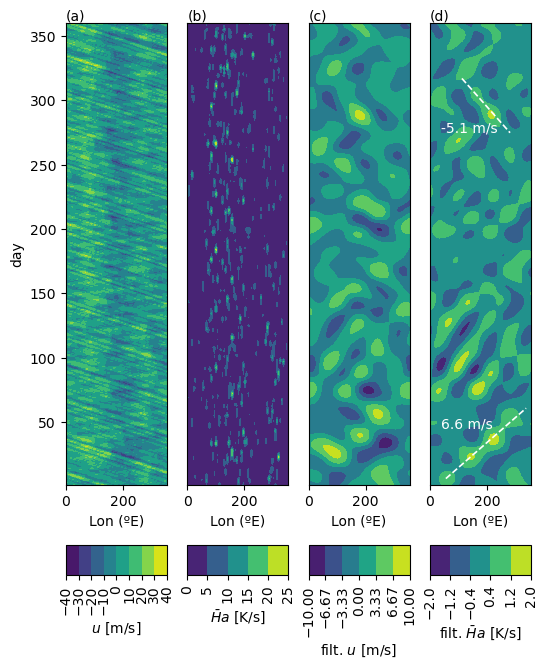

In [11]:
time_ = 1:360; 
space_ = range(0, stop=360-360/64.0, length=64) 
X = repeat(reshape(space_, 1, :), length(time_), 1);
Y = repeat(time_, 1, length(space_));


nr = 15
year = 2005.0; 
interval = findall(x->x==year, years_tracked);
fig, axs = subplots(1,4, figsize = (6,6))
im1 = axs[1].contourf(X,Y, u_daily[:,nr,interval]', levels = LinRange(-40, 40, 9) )
im2 = axs[2].contourf(X,Y, ha_daily[:,nr,interval]', levels = LinRange(0, 25, 6))
im3 = axs[3].contourf(X,Y, u_daily_filtered_space[:,nr,interval]', levels = LinRange(-10, 10, 7))
im4 = axs[4].contourf(X,Y, ha_daily_filtered_space[:,nr,interval]', levels = LinRange(-2, 2, 6))

p1 = axs[1].get_position().get_points()
p1 = [(p1...)...]
p2 = axs[2].get_position().get_points()
p2 = [(p2...)...]
p3 = axs[3].get_position().get_points()
p3 = [(p3...)...]
p4 = axs[4].get_position().get_points()
p4 = [(p4...)...]



ax_cbar1 = fig.add_axes([p1[1], -0.04, p1[2]-p1[1], 0.05])
ax_cbar2 = fig.add_axes([p2[1], -0.04, p2[2]-p2[1], 0.05])
ax_cbar3 = fig.add_axes([p3[1], -0.04, p3[2]-p3[1], 0.05])
ax_cbar4 = fig.add_axes([p4[1], -0.04, p4[2]-p4[1], 0.05])


cbar1 = colorbar(im1, cax=ax_cbar1, orientation="horizontal")
cbar2 = colorbar(im2, cax=ax_cbar2, orientation="horizontal")
cbar3 = colorbar(im3, cax=ax_cbar3, orientation="horizontal")
cbar4 = colorbar(im4, cax=ax_cbar4, orientation="horizontal")

ax_cbar1.set_xticklabels(ax_cbar1.get_xticklabels(), rotation=90)
ax_cbar2.set_xticklabels(ax_cbar2.get_xticklabels(), rotation=90)
ax_cbar3.set_xticklabels(ax_cbar3.get_xticklabels(), rotation=90)
ax_cbar4.set_xticklabels(ax_cbar4.get_xticklabels(), rotation=90)


ax_cbar1.set_xlabel(L"$u$ [m/s]")
ax_cbar2.set_xlabel(L"$\bar{H}a$ [K/s]")
ax_cbar3.set_xlabel(L"filt. $u$ [m/s]")
ax_cbar4.set_xlabel(L"filt. $\bar{H}a$ [K/s]")


axs[1].set_ylabel("day")

axs[1].set_xlabel("Lon (ºE)")
axs[2].set_xlabel("Lon (ºE)")
axs[3].set_xlabel("Lon (ºE)")
axs[4].set_xlabel("Lon (ºE)")

axs[2].set_yticks([])
axs[3].set_yticks([])
axs[4].set_yticks([])


axs[1].text(1, 362, "(a)")
axs[2].text(1, 362, "(b)")
axs[3].text(1, 362, "(c)")
axs[4].text(1, 362, "(d)")


# plot speed indications on panel (d) - change/adapt by hand 
a = -90/360;
b = 345;
line1 = a.*space_.+b;
axs[4].plot(space_[21:51], line1[21:51], color = "white", linestyle = "--", linewidth = 1.2)
axs[4].text(40, 275, "-5.1 m/s", color = "white")


a = 70/360;
b = -5;
line2 = a.*space_.+b;
axs[4].plot(space_[11:61], line2[11:61], color = "white", linestyle = "--", linewidth = 1.2)
axs[4].text(40, 45, "6.6 m/s", color = "white")

savefig("figures/hovmoller.png", dpi = 400, bbox_inches="tight")

# Plot power spectrum

In [20]:
function padreplicate(a, padSize)
    # Pad an array by replicating values.
    numDims = length(padSize);
    idx = [];
    for k = 1:numDims
        M = size(a)[k];
        onesVector = ones(Int, padSize[k]);
        push!(idx, vcat(onesVector, (1:M), M .*onesVector));
    end   
    return a[idx[1], idx[2]]
end
    

padreplicate (generic function with 1 method)

In [21]:
function spectrum(term, Nx, nd)
    
    for iii in 1:Nx
        term[iii,:] = term[iii,:] .- mean(term[iii,:]);
    end
    termhat = fftshift(fft(term)); term = 0;
    term = termhat.*conj(termhat)/nd/Nx/nd/Nx; termhat=0;
    term = log10.(term);
    return term
end


spectrum (generic function with 1 method)

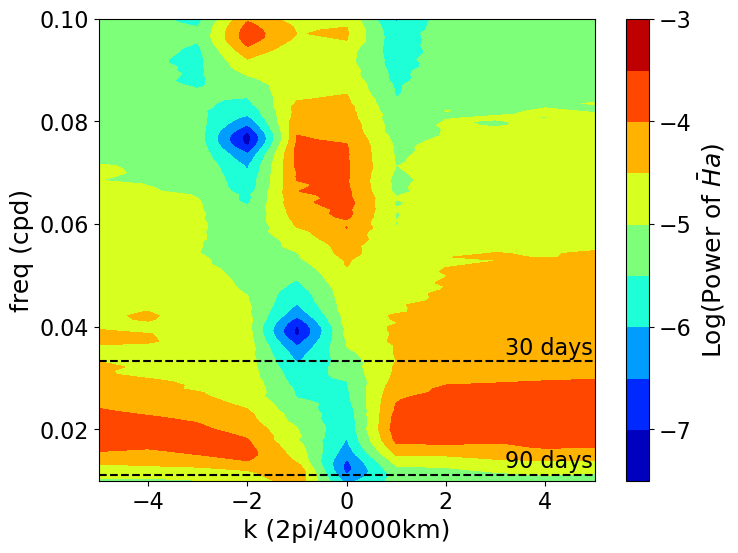

In [24]:
nxsmoo=     1; # x size of smooth (odd) (ref=1)
ntsmoo=     51; # t size of smooth (odd) (ref=25)
undersamplext=    1 ; # undersample outputs to be faster
nku=1; # k-space between samples 
nwu=11; # w-space between samples 

tcon=vcat(zeros(1),0:Nd-1);
ts = tcon; tcon = 0;

kg =-fftshift(fftfreq(Nx,Nx));
NNd = length(ts);
wg = fftshift(fftfreq(NNd,NNd))/NNd;


####################################
term = ha_daily[:,1,:];
xcon=((1:Nx)*0);
xcon=hcat(xcon,term);  
term_all = xcon; xcon = 0;

for nr in 2:NUM_REPEAT
    term = ha_daily[:,nr,:];
    
    xcon=((1:Nx)*0);
    xcon=hcat(xcon,term);  
    term = xcon; xcon = 0;
    
    term_all = term_all .+ spectrum(term, Nx, Nd)
end
term = term_all./NUM_REPEAT;
term_all = 0;

#############################

# smooth data
sz = [nxsmoo,ntsmoo]'; # x size of smooth, t size of smooth
padSize = Int.((sz .-1) ./2);
smooth_ = ones((sz[1],sz[2])) ./ (sz[1]*sz[2]); 

# pad data
X = padreplicate(term,padSize);
# perform the convolution
Y = conv(X, smooth_)  # Convolution (1 dimensional convolution, I think)

# Extract the 'valid' part of the result
Y_valid = Y[:,1:size(X)[2]];
Y_valid = Y_valid[:,padSize[2]+1:end-padSize[2]];

# undersample for figure
PSD=real.(Y_valid[1:nku:end,1:nwu:end]);
kg=kg[1:nku:end];
wg=wg[1:nwu:end]; 


################################

# graph ranges
xxrange=[-5,5]; yyrange=[1/100,0.1]; 
kwlevels= -7.5:0.5:-3;

# figure
fig = figure(figsize=(8,6))

aspect_ratio = (5 - (-5)) / (0.1 - (1 / 100))
contourf(kg, wg, PSD', levels = kwlevels,  cmap = :jet)
cbar = colorbar()

axhline(y = 1/30, linestyle = "--", color = "black")
text(3.2, 0.0345, "30 days", fontsize=16)
axhline(y = 1/90, linestyle = "--", color = "black")
text(3.2, 0.0125, "90 days", fontsize=16)

xlabel("k (2pi/40000km)", fontsize=18)
ylabel("freq (cpd)", fontsize=18)

xlim(xxrange)
ylim(yyrange)

cbar.set_ticks([-7,-6,-5,-4, -3])
cbar.set_label(L"Log(Power of $\bar{H}a$)", fontsize=18)
cbar.ax.tick_params(labelsize=16)

tick_params(axis="both", which="major", labelsize=16)

#savefig("figures/spectrum2.png", dpi = 400, bbox_inches="tight")


# climatological mean state and variance of convective activity

In [9]:
# reference values from observation

mean_state_obs = [0.63447047, 0.82385311, 1.05512592, 1.29748726, 1.41143023, 1.32072308, 1.07110377, 0.89125782, 0.65923143, 0.78365783, 0.97064447, 1.28288174, 1.49286871, 1.88178154, 1.90932694, 2.12785873, 2.48477829, 2.46821673, 2.35731323, 2.02154449, 2.48440132, 2.03148743, 1.85023753, 2.04074861, 2.40357981, 2.71217909, 2.64640965, 2.72319167, 2.57775551, 2.5080159 , 2.35830829, 2.24817153, 2.14220128, 1.99026377, 1.89041525, 1.76442461, 1.60944299, 1.46777352, 1.36271398, 1.28796875, 1.22224235, 1.17223835, 1.14222169, 1.11389481, 1.05066333, 1.07003877, 1.04454191, 1.08771372, 1.09866436, 1.24381045, 1.98811522, 2.2297906 , 2.41858673, 2.19152191, 2.0437829 , 2.08161911, 1.58913953, 1.46284294, 1.52265101, 1.20310833, 0.95069025, 0.82309336, 0.82941141, 0.60837749];
var_ha_obs = [0.43246531, 0.79090576, 0.90166614, 0.92764241, 0.94539983, 0.76263027, 0.80707566, 0.7501988 , 0.45969607, 0.550354  , 1.17024631, 1.62570271, 1.93585149, 2.2108578 , 2.19037681, 2.17013884, 2.99504139, 1.67945985, 1.5613739 , 1.15216685, 1.83886877, 1.63465783, 1.82081677, 1.93685682, 1.98879794, 2.79857672, 3.12145777, 2.64759241, 2.75669806, 1.72678987, 2.08827863, 1.32042655, 1.44514434, 1.17147252, 1.22025861, 0.98381031, 0.80393361, 0.71861616, 0.78857414, 0.79116691, 0.66827126, 0.6018239 , 0.68875867, 0.8182729 , 0.6242256 , 0.80900001, 0.7558489 , 0.72179167, 0.673626  , 0.79210501, 2.1637858 , 2.07509846, 1.98484548, 1.72748955, 2.2801776 , 2.33459525, 1.38794117, 0.92793855, 1.00869495, 0.57474102, 0.51992793, 0.58302229, 0.70899668, 0.48352196];
lon_obs = [  1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25, 18.75,  21.25,  23.75,  26.25,  28.75,  31.25,  33.75, 36.25,  38.75,  41.25,  43.75,  46.25,  48.75,  51.25, 53.75,  56.25,  58.75,  61.25,  63.75,  66.25,  68.75, 71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25, 88.75,  91.25,  93.75,  96.25,  98.75, 101.25, 103.75,106.25, 108.75, 111.25, 113.75, 116.25, 118.75, 121.25,123.75, 126.25, 128.75, 131.25, 133.75, 136.25, 138.75,141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25,158.75, 161.25, 163.75, 166.25, 168.75, 171.25, 173.75,176.25, 178.75, 181.25, 183.75, 186.25, 188.75, 191.25,193.75, 196.25, 198.75, 201.25, 203.75, 206.25, 208.75,211.25, 213.75, 216.25, 218.75, 221.25, 223.75, 226.25,228.75, 231.25, 233.75, 236.25, 238.75, 241.25, 243.75,246.25, 248.75, 251.25, 253.75, 256.25, 258.75, 261.25,263.75, 266.25, 268.75, 271.25, 273.75, 276.25, 278.75,281.25, 283.75, 286.25, 288.75, 291.25, 293.75, 296.25,298.75, 301.25, 303.75, 306.25, 308.75, 311.25, 313.75,316.25, 318.75, 321.25, 323.75, 326.25, 328.75, 331.25,333.75, 336.25, 338.75, 341.25, 343.75, 346.25, 348.75,351.25, 353.75, 356.25, 358.75];


In [10]:
ha_daily_filtered_smoothed = zeros(size(ha_daily_filtered))
maxk = 14
for nr in 1:NUM_REPEAT
    for ts in 1:Nd # filter each time step separately
        fH = fftshift(fft(ha_daily_filtered[:,nr,ts]));   
        freqs = fftshift(fftfreq(Nx, Nx));
        idx1 = findall(x-> abs(x) >maxk , freqs);
        fH[idx1].=0;
        
        ha_daily_filtered_smoothed[:,nr,ts] = real(ifft(ifftshift(fH)));
    end
end

mean_state = mean(ha_daily, dims = (2,3));

variance_ha = var(ha_daily_filtered[:,1,:], dims = 2);
for i in 2:NUM_REPEAT
    variance_ha = variance_ha .+ var(ha_daily_filtered[:,i,:], dims = 2);
end
variance_ha = variance_ha./NUM_REPEAT;


variance_ha_smoothed = var(ha_daily_filtered_smoothed[:,1,:], dims = 2);
for i in 2:NUM_REPEAT
    variance_ha_smoothed = variance_ha_smoothed .+ var(ha_daily_filtered_smoothed[:,i,:], dims = 2);
end
variance_ha_smoothed = variance_ha_smoothed./NUM_REPEAT;

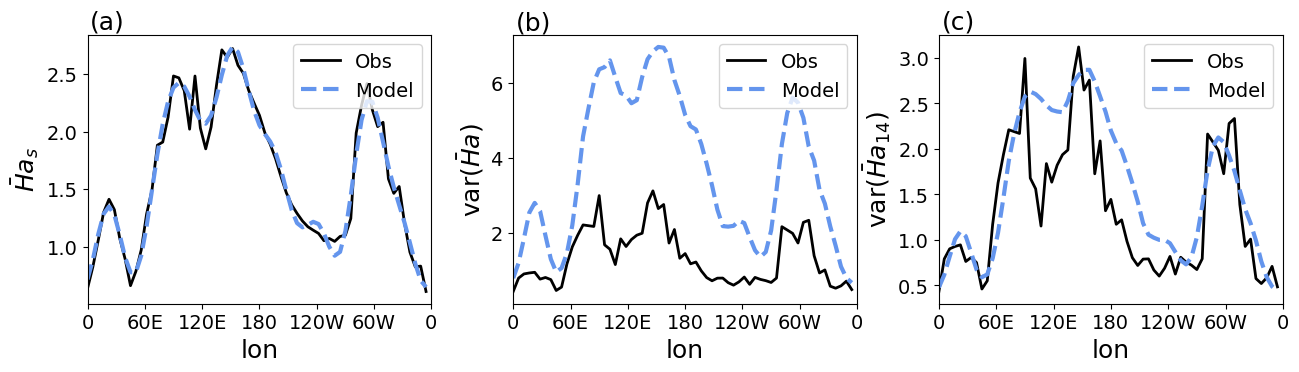

In [27]:


fig, axs = subplots(1,3, figsize = (14*0.94,4*0.94))#, constrained_layout=true)
fig.tight_layout(pad=2.8) 
#fig.subplots_adjust(hspace=0.6)

axs[1].plot(longitudes, mean_state_obs, label = "Obs", linestyle = "-", color = "black", linewidth = 2)
axs[1].plot(longitudes, mean_state[:,1,1], label = "Model", linestyle = "--", color = "cornflowerblue", linewidth = 3)

axs[1].set_xlabel("lon", fontsize = 18)
axs[1].set_ylabel(L"$\bar{H}a_s$", fontsize = 18)

axs[1].legend(fontsize =14, loc = "upper right")
axs[1].set_xlim([0, 358])
axs[1].set_xticks([0, 60, 120, 180,240, 300, 360])
axs[1].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W", "0"]);

axs[1].text( 3,2.9, "(a)", fontsize = 18)


axs[2].plot(longitudes, var_ha_obs, label = "Obs", linestyle = "-", color = "black", linewidth = 2)
axs[2].plot(longitudes, variance_ha, label = "Model", linestyle = "--", color = "cornflowerblue", linewidth = 3)

axs[2].set_xlabel("lon", fontsize = 18)
axs[2].set_ylabel(L"var($\bar{H}a$)", fontsize = 18)

axs[2].legend(fontsize =14)
axs[2].set_xlim([0, 358])
axs[2].set_xticks([0, 60, 120, 180,240, 300, 360])
axs[2].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W", "0"]);

axs[2].text( 3,7.42, "(b)", fontsize = 18)#3.05 6.8



axs[3].plot(longitudes, var_ha_obs, label = "Obs", linestyle = "-", color = "black", linewidth = 2)
axs[3].plot(longitudes, variance_ha_smoothed, label = "Model", linestyle = "--", color = "cornflowerblue", linewidth = 3)

axs[3].set_xlabel("lon", fontsize = 18)
axs[3].set_ylabel(L"var($\bar{H}a_{14}$)", fontsize = 18)

axs[3].legend(fontsize =14)
axs[3].set_xlim([0, 358])
axs[3].set_xticks([0, 60, 120, 180,240, 300, 360])
axs[3].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W", "0"]);

axs[3].text( 3,3.32, "(c)", fontsize = 18)#3.05 6.8

axs[1].tick_params(axis="both", which="major", labelsize=14)
axs[2].tick_params(axis="both", which="major", labelsize=14)
axs[3].tick_params(axis="both", which="major", labelsize=14)


#savefig("figures/clim_var_ha_obs_sim.png", dpi = 600, bbox_inches="tight", transparent = true)

# EOFs

In [11]:
# EOF from observed data (computed elsewhere)
PC1olr = [0.16326489726203747, 0.1759856117923969, 0.18703046178711005, 0.19742491262066644, 0.20425083338807373, 0.22048993464533795, 0.24394275294102416, 0.25016599928521716, 0.24475893311292432, 0.23688297101206995, 0.2150067289633688, 0.18555739741613758, 0.14202332628561423, 0.11179393465927549, 0.07552202456081973, 0.08732599724911363, 0.14221197286084522, 0.14862042259783104, 0.14430863684388068, 0.143781221841632, 0.1622943570952987, 0.17273643007087894, 0.18556415051006023, 0.20785424280083156, 0.2122475446800255, 0.20302668530281504, 0.18572323826532058, 0.15991791546733755, 0.13591259072316766, 0.11284669864116013, 0.092105061949284, 0.06895007398596614, 0.038051128017665935, -0.01783117767067244, -0.07732264630259052, -0.14364369267200902, -0.20881950779195496, -0.27060906800170087, -0.2813633715833328, -0.26845813068373364, -0.27935947777972264, -0.3593256607575326, -0.3842438204693056, -0.388101790400675, -0.399519940235253, -0.4329055065289274, -0.5273742570641352, -0.5449751880003556, -0.5304079060158289, -0.5255974573592436, -0.5394563341289631, -0.5542356469870188, -0.5589388496283106, -0.5457094485071426, -0.5306044566461791, -0.5302615648836917, -0.537636981474244, -0.5334613447109909, -0.5411992907905633, -0.5111178344458871, -0.4789467014589116, -0.44096040197339803, -0.40502048014180253, -0.361004790387811, -0.31446310245234044, -0.2663661823562112, -0.22984740986840468, -0.17617664666735497, -0.13535301573313924, -0.10173799187567056, -0.07626826195758972, -0.04149736088527073, -0.022227042262868552, -0.00467239985394152, 0.0029809923546523947, 0.010890714686787217, 0.018123222682458917, 0.02407865758802357, 0.027144236796721847, 0.029922880564497975, 0.02962255560024273, 0.0267476115244924, 0.01828080550933209, 0.008372284164441876, -0.011536472953650699, -0.024976798727060476, -0.03414980710773892, -0.043969838002738036, -0.049694299868950784, -0.04462716108681458, -0.03952056092318249, -0.03906526900923845, -0.038294075934796716, -0.03379027682954109, -0.027823314978810215, -0.01907063271996859, -0.006970884131503674, 0.014219858622782596, 0.03458828269924251, 0.063276788603095, 0.08508501649376549, 0.10783507281518616, 0.1245439404886126, 0.14064659236980467, 0.15301916715462538, 0.16819684865031256, 0.1764469540164517, 0.18182542434094445, 0.18314900893889996, 0.1897690127674452, 0.1468673493795294, 0.12907298732786832, 0.18173792539695963, 0.1659758244666644, 0.17372100691330541, 0.14209650719971775, 0.12062661603905837, 0.11976044084750931, 0.1154770924331102, 0.12151140963013309, 0.1153510986507598, 0.11891769022073692, 0.11610280609329227, 0.11292159491095433, 0.10829351879291624, 0.10258470994489115, 0.10721696682210702, 0.09926200943671745, 0.07575412816283392, 0.06042781809618781, 0.052364685486172236, 0.05662102773510257, 0.06068150187984112, 0.07237508330165406, 0.0837781042784879, 0.09833595425254177, 0.11349615664131187, 0.12172619201693088, 0.12516330096119957, 0.13018612417217243, 0.12455594107696662, 0.1315622084562831, 0.14712086473119484, 0.14731596460787844]; 
PC1u200 = [0.0548180516072389, 0.047172648113120476, 0.0362619147579688, 0.0215941187874123, 0.0060861322967104255, -0.007279917698517329, -0.01949113170259125, -0.0340451900289611, -0.051193612945119635, -0.06765882177967021, -0.08230003094706385, -0.09823933741802209, -0.1168869453826293, -0.1343121228687807, -0.1465868562209445, -0.15719140092184555, -0.1738157450327321, -0.19841727181265228, -0.22465205723812406, -0.24593820362820404, -0.26243015843659706, -0.27811846806063945, -0.2945053591282728, -0.310355667044925, -0.32541300281795815, -0.3409041299380737, -0.3571240631890272, -0.3729295094424113, -0.3877223476423072, -0.401513136486253, -0.41335426281319426, -0.4220503286880217, -0.4280438859922359, -0.4317307347304551, -0.4312691186557053, -0.42507384626488864, -0.4169939879392088, -0.41404424317848854, -0.41731220540250846, -0.419240040859146, -0.4139003085700772, -0.40570496315235144, -0.40328253333637765, -0.40624699074677906,                   -0.4047488760841115, -0.39205402166630193, -0.3723758941677715, -0.3537260146405263, -0.3378122167747039, -0.31972755715854057, -0.29551917065777705, -0.26545627436609853, -0.23203426235550986, -0.19788252335812875, -0.16505729601595695, -0.13367737983441727, -0.10093466702146395, -0.06411340446266885, -0.024230113980169943, 0.014964052813362291, 0.05196456566801125, 0.08876289810749088, 0.127080926146226, 0.16593347212657977, 0.20323786200894967, 0.237979772301459, 0.26977460066922454, 0.2978763611872095, 0.32209716572179925, 0.34410405849783765, 0.3657337016954879, 0.3872087963017232, 0.40758334150828074, 0.4270296498008554, 0.4470275067428355, 0.4685586519701106, 0.49078774497508515, 0.5120890167608547, 0.5310347202315928, 0.547469069753027, 0.5619849375138455, 0.5749777488910821, 0.5856267989137243, 0.592803596141602, 0.5963799692278005, 0.5975023788580188, 0.5972231351625656, 0.5960524569775473, 0.5944634837438696, 0.5933715233497735, 0.5928537515884382, 0.5923990978908118, 0.5924319113160696, 0.5944670062523666, 0.5988844064268202, 0.6040672465701092, 0.6089268546173431, 0.6144063787992475, 0.6210626171403947, 0.6268578227564217, 0.629278322065845, 0.6286789978888759, 0.6269535774987983, 0.6240527358856394, 0.6185650578820292, 0.6108327271674484, 0.6019686557425449, 0.5899088469970789,                     0.5713940621860966, 0.548464524299, 0.5276882878244219, 0.5107823214611843, 0.4902533422387041, 0.45935585602566836, 0.4227757522117378, 0.391648478769109, 0.36969387911963203, 0.3503058291126259, 0.32819448393064476, 0.3066024205696104, 0.2907344950182449, 0.2792424659234617, 0.26712070838890506, 0.2537811732180673, 0.24334102047537243, 0.2378939676576901, 0.23418544052797974, 0.22818074172057426, 0.21870532424066702, 0.20661112043354082, 0.1925779431062456, 0.17704369006275036, 0.16067042037364734, 0.14378418562332082, 0.12643684599603192, 0.10975365515495228, 0.09559767242596331, 0.08475015046709228, 0.07655669503242185, 0.07058845752488599, 0.06738793609106944, 0.06617801098001863, 0.06446604421590373, 0.060629411418547344 ];
PC1u850 = [-0.07214012463843607, -0.06609287541234857, -0.06319607710940268, -0.061884654486937106, -0.05899668190079056, -0.05183424200168447, -0.03899968847887109, -0.022046298226758305, -0.006882433333640807, 0.0027908924073848295, 0.011894365791918618, 0.030020113686410766, 0.05711227910525834, 0.08160229144462908, 0.09570266267133581, 0.10716512225728954, 0.12955052676183978, 0.1630399923298228, 0.19472917439421614, 0.21689318513325512, 0.23834301099799365, 0.272608912326593, 0.3205011114139454, 0.369810350028075, 0.4115153553994102, 0.4470288645394594, 0.48065997109550035, 0.5115108436600745, 0.53818165041461, 0.566396337784535, 0.6029064783804287, 0.6445664075469254, 0.6794307455063279, 0.7022057126719808, 0.7179825098509736, 0.7288145052678202, 0.7258117355609088, 0.706432040263977, 0.6874182108310196, 0.687689170670288, 0.699952914661127, 0.6987161776867262, 0.6765718003004273, 0.6552165953594415, 0.6524824537586067, 0.6555228023281918, 0.6411295467247258, 0.6099032695117498, 0.581053675740693, 0.5599682270510858, 0.5324585226979576, 0.4903302093842519, 0.44516014919145647, 0.4080477823768285, 0.3723474852605793, 0.32687760438073293, 0.27411743461366384, 0.2240044919587638, 0.17744209184703608, 0.12684429317202883, 0.07010555695673994, 0.013868152789277147, -0.03726167467866237, -0.08587304134082631, -0.13555770761226882, -0.18612755674756726, -0.23516612018885363, -0.2810174958471147, -0.32134409780723033, -0.35469164799395086, -0.38313650562172624, -0.4105832857501884, -0.43699808761311265, -0.4597723706257115, -0.4789981485237841, -0.4989668184563914, -0.522430131945371, -0.547868875139863, -0.5714994662868627, -0.5900980723581873, -0.602038212079903, -0.6079448581776357, -0.6104574986446514, -0.612344999683473, -0.6141226465459334, -0.6153302840869316, -0.6170077917300129, -0.6197709754440818, -0.6218644130897986, -0.6217453664918617, -0.6205743066042463, -0.6209286930679337, -0.6229270741130671, -0.6250901034379935, -0.6281006390378228, -0.633202976153101, -0.639284790661873, -0.6454224601060001, -0.6535629120322136, -0.6636173162602377, -0.668290489638466, -0.6603491746068799, -0.6437396376890179, -0.628087642320183, -0.6136798356716334, -0.5919848729089797, -0.562820905796927, -0.5390136455142818, -0.527229147611654, -0.5164433872373392, -0.49407706090478604, -0.4629311238649918, -0.4331289904644415, -0.4027940973976576, -0.36432082321434656, -0.32325181839269956, -0.2956786145049739, -0.2861290660621156, -0.28235987164034015, -0.2751880758721539, -0.26955179891430203, -0.2701688320074428, -0.27090956277003003, -0.2657468590345844, -0.25922377425431975, -0.25740625941841566, -0.2545769615439987, -0.24051532698252032, -0.2166280387590761, -0.19456038698194011, -0.18084381653255954, -0.17233566511115478, -0.16507362603700532, -0.15961140476436006, -0.1547436691417439, -0.14584783228000664, -0.13131568432217008, -0.11581729469380589, -0.10463033389757319, -0.09817122257450865, -0.09406346514112861, -0.09067144982528237, -0.08641722022901602, -0.079988108197747];
PC2u200 = [0.5606122785192678, 0.5620143142175527, 0.5608559275246098, 0.5586055112881533, 0.5540287046031256, 0.5449779642034742, 0.5335540791819215, 0.5246741642471247, 0.5199648071994191, 0.5183301861419654, 0.5212862359008291, 0.5318211398627878, 0.5462975896489202, 0.5561878879886422, 0.5607132314270514, 0.5706289264971085, 0.5938091487821588, 0.6230528371195554, 0.6444837997847045, 0.6536485502325123, 0.6558323197058581, 0.654497474531317, 0.6473584849399747, 0.6338721726970937, 0.6175702210737706, 0.5998298213897058, 0.5778504613083544, 0.5507306083570314, 0.5218364090262564, 0.4929714429156967, 0.4612360913993192, 0.4237674736975824, 0.3820154174925288, 0.3384790227007424, 0.2928504823261038, 0.24459022495938867, 0.1957666148497356, 0.14907626117969572, 0.1048140121234893, 0.0623668836686634, 0.021616186092309465, -0.01851634437953297, -0.05986297207058823, -0.10086426869652444, -0.13613621085832486, -0.1632682968257471, -0.18694769043177212, -0.21290183044145963, -0.239882935409068, -0.26262479207269734, -0.28001863503588587, -0.2959088036549631, -0.3119818543675928, -0.3256195011878804, -0.3348421997862249, -0.3408294505445836, -0.3450032147605304, -0.3469535292359701, -0.34686041311437504, -0.34635953814170367, -0.3457741422605186, -0.343075822122162, -0.33716985141283073, -0.32957429872776095, -0.32157735572810325, -0.31226312603058687, -0.30067010511719555, -0.28827959791410745, -0.277194740480901, -0.26747714878649315, -0.2576475514319738, -0.24703101663510144, -0.23571241714375044, -0.22366170742666247, -0.2108869780955897, -0.19784739977082952, -0.18404506415689273, -0.16830004884301974, -0.15019453467235666, -0.13102419811943544, -0.11235964602011383, -0.09445286477717046, -0.07689952399184125, -0.059330200685434153, -0.04078442775213852, -0.019828936757622456, 0.0036209454340474724, 0.028318625788887268, 0.05409491789009105, 0.08280135699878786, 0.11519819203332923, 0.14910117153843605, 0.18232214908461367, 0.21535575889267147, 0.24925603625018009, 0.282308436385999, 0.3112323164649821, 0.3346686993814872, 0.35376559477222363, 0.36964604878268587, 0.3827423160642362, 0.39393741020893086, 0.4042499806375262, 0.4141445961428893, 0.4241289030429699, 0.4351691896116502, 0.4466786238810674, 0.45579082585421316, 0.4604220890762355, 0.4614850987159212, 0.459308051445197, 0.44997877121695823, 0.42926154652028753, 0.3999198338710765, 0.37041811581292183, 0.34625972404536676, 0.32667662794880814, 0.3099925852278517, 0.297843488175161, 0.2918735743918889, 0.29034184270601027, 0.2910441666345605, 0.294206231356767, 0.30081948866440034, 0.3101352020509041, 0.3219843137748771, 0.33815475589267857, 0.35930389059145723, 0.38233143936238595, 0.40368807404958496, 0.4237120246353326, 0.44444615870413295, 0.46570247490248445, 0.4855561736266695, 0.5032171732320795, 0.518561248123035, 0.5301331505268965, 0.5368650326195454, 0.5405071865467519, 0.543824150141284, 0.5472186655717393, 0.549692887747917,             0.5523373423839358, 0.5564734616781157];
PC2olr = [0.01861346641993595, 0.03563020099161776, 0.05462511445230891, 0.0530662075450297, 0.025880437404173777, 0.013722918915871666, 5.0333866365692776e-05, 0.024037116976763608, 0.02347946802765511, 0.011902266854114002, 0.02255546055335951, 0.0406992325072771, 0.11031764635972904, 0.18102829375775867, 0.19744330048948053, 0.13138970428078472, 0.08271234053487837, 0.08130918086226425, 0.09358899880332607, 0.11169580351549843, 0.13791667486958287, 0.18385437332158652, 0.2310034368481538, 0.2735927712647485, 0.3211024169755951, 0.3663907988926446, 0.419807330565667, 0.4842416050481519, 0.5514232691500102, 0.6057592658696234, 0.6329991277111647, 0.6665401249310972, 0.7138404643832001, 0.7550878743556958, 0.7759197980490979, 0.7758963829645358, 0.7514606682806052, 0.7056615722260311, 0.6448304607779473, 0.5627111502451397, 0.4835708705496762, 0.40476303742035086, 0.3874073520547808, 0.37601059568728545, 0.3226475186596889, 0.23699915899866064, 0.12423318367265113, 0.11278422182106192, 0.08706538612004697, 0.08783278135339766, 0.07268118713250254, 0.050173245472574346, 0.02847837607657943, -0.0026490090183090777, -0.009881104138352146, -0.03690499013618945, -0.0797075050715276, -0.10683568201358663, -0.15484906343922317, -0.18714372927104297, -0.18237751217019865, -0.17169884774390992, -0.19722521819150637, -0.2058530567433309, -0.21747061747711843, -0.22070169761915523, -0.22445607604634119, -0.21916663044525825, -0.21986716125757177, -0.21596735843230971, -0.21174322435880147, -0.21246040561886737, -0.2057091987682411, -0.19433070635222185, -0.17862615775244786, -0.16485949078710282, -0.15886444111141657, -0.1401956801841201, -0.13264066711174646, -0.11925826009916259, -0.10265407936019699, -0.08918950547074013, -0.08380130273879731, -0.08202747112629286, -0.07902606340917924, -0.07393143850501491, -0.06983927840462194, -0.07146345572426845, -0.07534947460676793, -0.07265739287427932, -0.07342995916615816, -0.06773129875512097, -0.05657223440327073, -0.05089129770118371, -0.057916874806609564, -0.06655593404305095, -0.07126740972197937, -0.07336281180258976, -0.07411040142622881, -0.0675865798295116, -0.06693538795515996, -0.05888166190589749, -0.05043108477407376, -0.0432015030891421, -0.04079486172215605, -0.0377219790598462, -0.038765501766418416, -0.04204597766646729, -0.04371264610538185, -0.047441674120060694, -0.05455287817285771, -0.039210040167243686, 0.010061243372548979, 0.014369727168407714, -0.0021192155522478306, -0.020238447729111507, -0.039531773444849885, -0.04857063097619528, -0.04016519586308011, -0.0211937019016831, -0.019923121462571847, -0.016797748095275785, -0.01360366511555678, 0.0018871632596272221, -0.00366069848682752, -0.02261964994396457, -0.038709829499984034, -0.05112244140471948, -0.04889048974923294, -0.0479452615766999, -0.05884853105075058, -0.06467026231057513, -0.07386243073943469, -0.0815962908067008, -0.09307881812191098, -0.09417184279023691, -0.09266549860309342, -0.0849897533838121, -0.0817443699547531, -0.0757259201387179, -0.06195846496401979, -0.04167508819161059, -0.019297606982062496, -0.0009043094357184184];
PC2u850 = [-0.12634655012181367, -0.1322993250772416, -0.13996202358529697, -0.15167453532658576, -0.16427013111555824, -0.17186482663945055, -0.1769525401982554, -0.18814672114108386, -0.2039576746416707, -0.2123868571860166, -0.21339128263434093, -0.2259930767645661, -0.258251639699384, -0.28482566425874006, -0.27538895443069755, -0.23919991171936114, -0.21656214802748575, -0.22604695458245236, -0.24402494504645109, -0.24543641701386193, -0.2397788350995324, -0.25129609739042985, -0.279165691682539, -0.3011301688115557, -0.30749064103885626, -0.3086397430384197, -0.31243561607165476, -0.3117961986458, -0.299146721267649, -0.2767391692110672, -0.24800216500393732, -0.2108734121653816, -0.16563690965883573, -0.11793292156130813, -0.06950137802572699, -0.01671449824143596, 0.037871886815594724, 0.08420889964529349, 0.12260534129408888, 0.16945654005801455, 0.23429140254831962, 0.30212084836333497, 0.35198486867061873, 0.3862647496020982, 0.42401453368126535, 0.47187088589935994, 0.5177661278668277, 0.5539812445564104, 0.5879568267941423, 0.6260086817953397, 0.6615993039571049, 0.6893581364185714, 0.7172647392571186, 0.7525683761991224, 0.7853007457997783, 0.7983803007276709, 0.790297303387255, 0.7757034473736915, 0.7648445053611482, 0.7560484231128515, 0.7469138458831982, 0.7416325045889601, 0.74226406295457, 0.7434650346816823, 0.7403174913568509, 0.7355606194268917, 0.7336223869918199, 0.7312248113148453, 0.7220497923854647, 0.7056624003291152, 0.6859606171906737, 0.6642011714284336, 0.638027371141616, 0.6079349869852189, 0.5788608802878938, 0.5540703545044641, 0.5319619381456603, 0.509465098672898, 0.48617137002957383, 0.4629547738577338, 0.43901890132572263, 0.4133565474672688, 0.3858782145377394, 0.35730418400663005, 0.3275265412720957, 0.2970362428278329, 0.2675479025475827, 0.24036515109101284, 0.21474117777793775, 0.18914136657048533, 0.16388336030069064, 0.14047314526160345, 0.11968910416986767, 0.10040390204486337, 0.08130648418699583, 0.06238921593724285, 0.04412020768529852, 0.02728038644418246, 0.01266840268284428, 0.001120387959427995, -0.00746458228356708, -0.013785500533079316, -0.018797283306320564, -0.022521420979981898, -0.023789955210164356, -0.021907553148629515, -0.01800230963533334, -0.01563839789919291, -0.017707712428454227, -0.022791375476134853, -0.025348577578428007, -0.022209768465892236, -0.016299331579506863, -0.012881935012280838, -0.011977685123428911, -0.009779889535213368, -0.005159140413146817, -0.0026961721993617525, -0.00538470777737514, -0.010703703369985378, -0.014579600703560992, -0.01878123928720051, -0.026371800134931293, -0.03585194110184573, -0.04305333772898586, -0.048528357731468484, -0.05691014529150071, -0.06833501154972099, -0.077476004103316, -0.08189110398900111, -0.08637297592757576, -0.09510321302009636, -0.10528225517609267, -0.112280443692266, -0.11689776907273818, -0.12122427618358111, -0.12366346043636782, -0.12245412014575893, -0.12071131959656552, -0.12290614732384575, -0.12641404325107577, -0.1261259453120665, -0.12271721718372983, -0.12218139387565848];
lon_interp = [  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. , 22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5, 45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. , 67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5, 90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,112.5, 115. , 117.5, 120. , 122.5, 125. , 127.5, 130. , 132.5,135. , 137.5, 140. , 142.5, 145. , 147.5, 150. , 152.5, 155. ,157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5, 175. , 177.5,180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5, 200. ,202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. ,247.5, 250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5,270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5, 290. ,292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. , 312.5,315. , 317.5, 320. , 322.5, 325. , 327.5, 330. , 332.5, 335. ,337.5, 340. , 342.5, 345. , 347.5, 350. , 352.5, 355. , 357.5]

itp = LinearInterpolation(lon_interp, PC1olr) # create interpolation function
PC1_olr = itp(longitudes);

itp = LinearInterpolation(lon_interp, PC2olr) # create interpolation function
PC2_olr = itp(longitudes);

itp = LinearInterpolation(lon_interp, PC1u200) # create interpolation function
PC1u200 = itp(longitudes);

itp = LinearInterpolation(lon_interp, PC2u200) # create interpolation function
PC2u200 = itp(longitudes);

itp = LinearInterpolation(lon_interp, PC1u850) # create interpolation function
PC1u850 = itp(longitudes);

itp = LinearInterpolation(lon_interp, PC2u850) # create interpolation function
PC2u850 = itp(longitudes);

PC1_ = vcat(PC1u200, PC1u850, PC1_olr);
PC2_ = vcat(PC2u200, PC2u850, PC2_olr);

PC1_ref = PC1_[65:end]; 
PC2_ref = PC2_[65:end];

In [12]:
# compute "mean" PC over 15 independent runs

Nd = size(ha_daily)[3];
SMM1 = zeros(NUM_REPEAT, Nd);
SMM2 = zeros(NUM_REPEAT, Nd);
amplitude = zeros(NUM_REPEAT, Nd);
phase = zeros(NUM_REPEAT, Nd);

i=1
var1, var2, PC1, PC2, amplitude[1,:], phase[1,:], SMM1[1,:], SMM2[1,:] = smm.SMM(sim_day, u_daily_filtered[:,i,:], ha_daily_filtered[:,i,:]); #var1, var2, 
for i in 2:NUM_REPEAT
    var1_tmp, var2_tmp, PC1_tmp, PC2_tmp, amplitude[i,:], phase[i,:], SMM1[i,:], SMM2[i,:] = smm.SMM(sim_day, u_daily_filtered[:,i,:], ha_daily_filtered[:,i,:]); #var1, var2, 
    var1 = var1 + var1_tmp;
    var2 = var2 + var2_tmp;
    PC1 = PC1 .+ PC1_tmp;
    PC2 = PC2 .+ PC2_tmp;
end
var1 = var1 / NUM_REPEAT;
var2 = var2 / NUM_REPEAT;
PC1 = PC1 ./ NUM_REPEAT;
PC2 = PC2 ./ NUM_REPEAT;

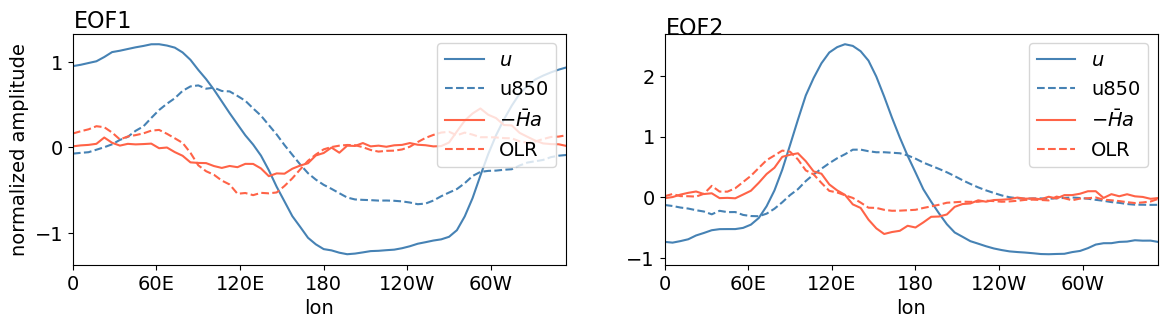

In [21]:
# model vs observations
fig, axs = subplots(1,2, figsize = (14,3))

axs[1].plot(longitudes, PC1[1:64]./var1, label = L"$u$", color = "steelblue")
axs[1].plot(longitudes, PC1_ref[1:64], label = "u850", linestyle = "--", color = "steelblue")

axs[1].plot(longitudes, PC1[65:end]./var1, label = L"$-\bar{H}a$", color = "tomato")
axs[1].plot(longitudes, PC1_ref[65:end], label = "OLR", linestyle = "--", color = "tomato")

axs[2].plot(longitudes, PC2[1:64]./var2, label = L"$u$", color = "steelblue")
axs[2].plot(longitudes, PC2_ref[1:64], label = "u850",linestyle = "--", color = "steelblue")

axs[2].plot(longitudes, PC2[65:end]./var2, label = L"$-\bar{H}a$", color = "tomato")
axs[2].plot(longitudes, PC2_ref[65:end], label = "OLR", linestyle = "--", color = "tomato")




axs[1].text(1, 1.4, "EOF1", fontsize = 16)
axs[2].text(1, 2.68, "EOF2", fontsize = 16)


axs[1].set_xlabel("lon", fontsize=14)
axs[2].set_xlabel("lon", fontsize=14)

axs[1].set_ylabel("normalized amplitude", fontsize=14)

axs[1].legend(fontsize=14, loc="upper right")
axs[2].legend(fontsize=14)

axs[1].set_xlim([0, 354])
axs[2].set_xlim([0, 354])

axs[1].set_xticks([0, 60, 120, 180,240, 300])
axs[1].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W"]) 

axs[2].set_xticks([0, 60, 120, 180,240, 300])
axs[2].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W"]) 

axs[1].tick_params(axis="both", which="major", labelsize=14)
axs[2].tick_params(axis="both", which="major", labelsize=14)

#savefig("EOFs.png", dpi = 600,  bbox_inches="tight")

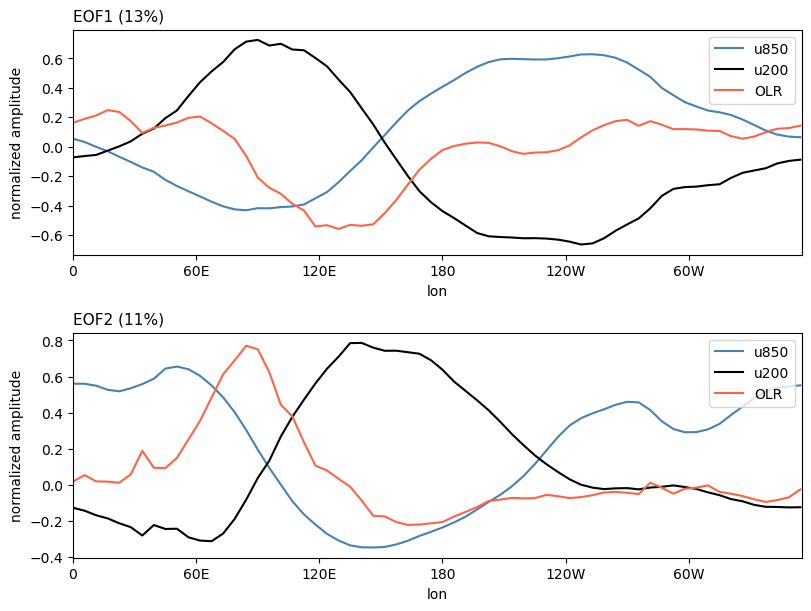

(0.0, 355.0)

In [31]:
# observations only
fig, axs = subplots(2,1, figsize = (8,6),constrained_layout=true)

axs[1].plot(longitudes, PC1_[1:64], label = "u850", linestyle = "-", color = "steelblue", alpha = 1)
axs[1].plot(longitudes, PC1_[65:128], label = "u200", linestyle = "-", color = "black", alpha = 1)
axs[1].plot(longitudes, PC1_[129:end], label = "OLR", color = "tomato", alpha = 1)

axs[2].plot(longitudes, PC2_[1:64], label = "u850", linestyle = "-", color = "steelblue", alpha = 1)
axs[2].plot(longitudes, PC2_[65:128], label = "u200", linestyle = "-", color = "black", alpha = 1)
axs[2].plot(longitudes, PC2_[129:end], label = "OLR", color = "tomato", alpha = 1)


#axs[1].plot(longitudes, PC1_[1:64], label = "PC1 u", linestyle = "--")
#axs[1].plot(longitudes, PC1_[65:end], label = "PC1 -ha")
#axs[2].plot(longitudes, PC2_[1:64], label = "PC2 u", linestyle = "--")
#axs[2].plot(longitudes, PC2_[65:end], label = "PC2 -ha")

#axs[1].text(1, 0.2, round(VAR1*100, digits = 1))
#axs[2].text(350, 0.15, round(VAR2*100, digits = 1))


axs[1].set_xlabel("lon")
axs[2].set_xlabel("lon")

axs[1].set_ylabel("normalized amplitude")
axs[2].set_ylabel("normalized amplitude")

axs[1].set_title("EOF1 (13%)", loc="left", fontsize=11)
axs[2].set_title("EOF2 (11%)", loc="left", fontsize=11)

axs[1].legend(loc="upper right")
axs[2].legend(loc="upper right")

axs[1].set_xticks([0, 60, 120, 180,240, 300, 360])
axs[1].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W", "0"]) 

axs[2].set_xticks([0, 60, 120, 180,240, 300, 360])
axs[2].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W", "0"]) 

axs[1].set_xlim([0, 355])
axs[2].set_xlim([0, 355])

#savefig("EOFs_ref.eps", dpi = 400, format="eps", bbox_inches="tight")

## patern correlation

In [32]:
println("Correlation between PC1s for u : ", cor(PC1[1:64],PC1_ref[1:64]))
println("Correlation between PC1s for ha : ", cor(PC1[65:end],PC1_ref[65:end]))
println("Correlation between PC2s for u : ", cor(PC2[1:64],PC2_ref[1:64]))
println("Correlation between PC2s for ha : ", cor(PC2[65:end],PC2_ref[65:end]))
println("Sum:",  cor(PC1[1:64],PC1_ref[1:64]) + cor(PC1[65:end],PC1_ref[65:end]) + cor(PC2[1:64],PC2_ref[1:64]) + cor(PC2[65:end],PC2_ref[65:end]))

Correlation between PC1s for u : 0.7340454748363239
Correlation between PC1s for ha : 0.7594842319628645
Correlation between PC2s for u : 0.7626100974180969
Correlation between PC2s for ha : 0.8696517888369839
Sum:3.1257915930542692


# Identification of MJO events

In [13]:
# identify MJO events using the RMM index and further constraints (see thesis)
# store (first day, last day) of each event in a sequence  
seqs = []
for nr in 1:NUM_REPEAT
    seq = events.identify(amplitude[nr,:], phase[nr,:]);
    push!(seqs,seq);
end

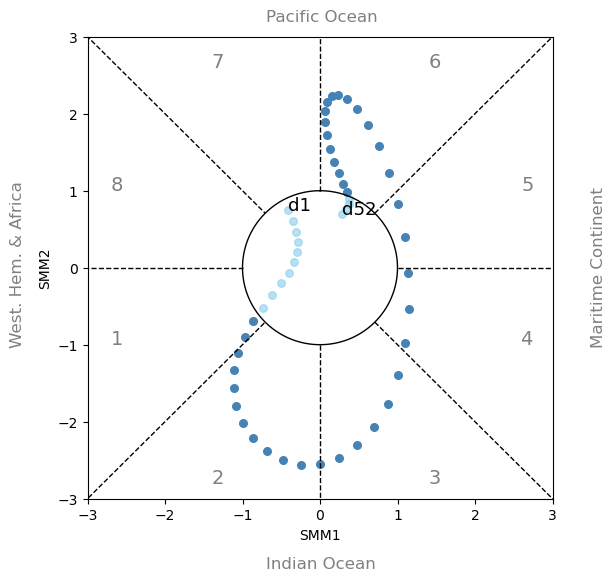

In [14]:
# select one event and plot its phase-space diagram
j = 20 #
ii1 = Int(seqs[1][j,:][1])-10;
ii2 = Int(seqs[1][j,:][2])+4;
events.phase_space_diagram(SMM1[1,:], SMM2[1,:], ii1, ii2, amplitude[1,:], ii1, ii2, ii1+10, ii2-4, "d1", "d52", 13)

# Seasonal variability

count number of events in each month

In [35]:
seasonal_var = zeros(12);
for nr in 1:NUM_REPEAT
    seq = seqs[nr];
    num_events = size(seq)[1];
    for i in 1:num_events
        m1 = Int(seq[i,1]);
        m2 = Int(seq[i,2]);
        event_months = months_tracked_[m1:m2];
        for em in unique(event_months)
            seasonal_var[Int(em)]+=1;
        end
    end
end

In [36]:
#reference from observations
seasonal_ref = [34.0, 30.0, 41.0, 38.0, 39.0, 25.0, 11.0, 9.0, 14.0, 28.0, 25.0, 35.0];

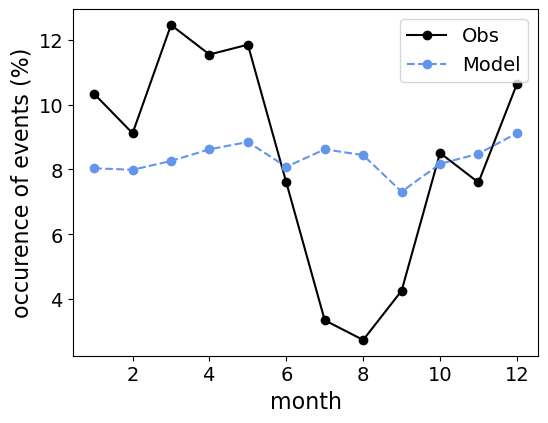

In [37]:
fig, ax = subplots(1,1, figsize = (4*1.5,3*1.5))

ax.plot(1:12,seasonal_ref./sum(seasonal_ref)*100, "-o", label = "Obs", color = "black") 
ax.plot(1:12,seasonal_var./sum(seasonal_var)*100, "--o", label = "Model", color = "cornflowerblue") # might be shifted backwards by 15 days

ax.set_xlabel("month", fontsize = 16)
ax.set_ylabel("occurence of events (%)", fontsize = 16)

ax.legend(fontsize = 14)
ax.tick_params(axis="both", which="major", labelsize=14)

#savefig("figures/seasonality.eps", dpi = 400, format="eps", bbox_inches="tight")


# Number of events 

In [38]:
# mean number of events and standard deviation over all independent runs
num_events = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    num_events[nr] = events.number(seqs[nr]);
end
mean_num_events = mean(num_events);
std_num_events = std(num_events);
println("Average total number of events :", mean_num_events, " +/- ", std_num_events/sqrt(NUM_REPEAT))
println("Average number of events per year : ", mean_num_events/(Nd/365), " +/- ",  std(num_events/sqrt((Nd/365))))

Average total number of events :65.33333333333333 +/- 1.5966234212256658
Average number of events per year : 1.546476437527021 +/- 0.9513763925655547


# MJO lifetime, extent in RMM phase space and maximum amplitude

In [15]:
# reference values from observation

duration_ref = [43.0, 51.0, 35.0, 38.0, 48.0, 20.0, 18.0, 34.0, 19.0, 18.0, 21.0, 42.0, 65.0, 70.0, 18.0, 20.0, 18.0, 39.0, 36.0, 43.0, 36.0, 26.0, 39.0, 22.0, 31.0, 14.0, 37.0, 45.0, 29.0, 21.0, 76.0, 16.0, 48.0, 52.0, 153.0, 24.0, 14.0, 54.0, 40.0, 21.0, 21.0, 29.0, 18.0, 30.0, 23.0, 45.0, 41.0, 24.0, 32.0, 23.0, 43.0, 35.0, 23.0, 16.0, 51.0, 41.0, 43.0, 47.0, 24.0, 44.0, 64.0, 17.0, 43.0, 17.0, 25.0, 75.0, 25.0, 27.0, 35.0, 39.0, 81.0, 60.0, 31.0, 32.0, 24.0, 40.0, 14.0, 25.0, 85.0, 29.0, 46.0, 20.0, 15.0, 14.0, 65.0, 22.0, 77.0, 30.0, 25.0, 31.0, 20.0, 24.0, 70.0, 23.0, 14.0, 51.0, 26.0, 50.0, 30.0, 24.0, 37.0, 19.0, 100.0, 25.0, 41.0, 48.0, 29.0, 52.0, 29.0, 40.0, 21.0, 29.0, 29.0, 17.0, 17.0, 12.0, 19.0, 23.0, 32.0, 28.0, 86.0, 25.0, 81.0, 13.0, 29.0, 28.0, 28.0, 16.0, 25.0, 38.0, 38.0, 62.0, 45.0, 40.0, 26.0, 25.0, 19.0, 55.0, 25.0, 14.0, 89.0, 26.0, 33.0, 23.0, 73.0, 56.0, 49.0, 22.0, 47.0, 20.0, 64.0, 11.0, 37.0];
angle_ref = [8.231361433980151, 6.521913674678556, 4.937017439860323, 2.618226747303696, 5.706097255485039, 3.730330878309978, 2.633462368347161, 5.408194160006371, 2.956117791002831, 3.5618588414097965, 2.8872830332496444, 3.7839027323578986, 5.553338762188588, 6.841554694360584, 3.6057756256524347, 3.4274333776136667, 2.6141842718143913, 6.552369697082918, 3.9269210269915673, 5.2888599039434085, 4.617199937606468, 3.746135696437136, 5.637561733489105, 2.3960088468369354, 4.090287590407964, 2.43081649403295, 4.853887796727675, 3.0620697825564944, 3.168755379906231, 2.4718202325857392, 9.37262907567839, 3.872392809929147, 4.971801147025561, 6.608608184067237, 21.209269111460685, 4.868761227527477, 2.5165781009680463, 7.923671223634278, 2.59677984127235, 2.81386676945623, 3.14234826245822, 2.4218733054948225, 2.45068034970608, 4.749885857483365, 2.5410377691324246, 6.909045162995007, 6.319761076064756, 5.019348616137907, 4.847470307310038, 2.6663179626412434, 4.076564382369301, 4.1269530453301515, 2.4564385001992144, 2.5782776978893773, 8.15715119076666, 2.545396290471709, 5.32453927945679, 6.300756483517633, 3.509313436653891, 5.732763590042552, 5.592491016078137, 2.970904829508907, 6.493083833421072, 3.817282665232919, 2.56629994895041, 8.68796385224021, 2.5327228929215897, 2.5265597305042133, 3.436686937017445, 3.7097553548905937, 11.695544963750262, 4.214625716440128, 3.025691583987051, 3.6883205117187376, 3.0226759635853955, 4.7923788711573, 2.751019351875076, 4.246793293722759, 10.945866405251408, 4.33171905482677, 5.94549109321282, 2.6084162514964118, 2.4885666893241023, 3.0275241995686066, 5.6755845252091355, 3.1870126281239854, 8.962267446391477, 4.229345892465792, 3.6507747266569206, 2.7579345304254343, 3.4943697814461525, 3.574236643329646, 12.032264358147495, 3.5482172743092724, 3.1057751250566, 7.303924432831236, 3.000111986420371, 6.47164866541652, 2.4571058875569314, 3.0691065931853645, 4.082680538059893, 2.4654836674739373, 15.387221661985624, 3.1419969305641113, 5.546615828836607, 3.848135840141258, 3.851286232953449, 7.919710064372241, 2.608563977974617, 5.940693324369062, 3.9838619367388524, 2.686943039155107, 4.099183167920551, 2.564227516023216, 2.936055908898063, 2.461648510966678, 2.9854359685748775, 3.9650343297618256, 3.6746978841251288, 4.092356318315287, 9.960910355342008, 3.141345096795246, 10.413694510310032, 2.8185458226631854, 4.67062663983932, 2.4419568744719813, 3.5038024426000836, 2.919586105680818, 4.142248114574398, 3.4726653676834345, 5.486213696481422, 6.652712597446654, 4.913627678106008, 4.045225908576436, 3.9860825235965907, 4.299087869372429, 4.384123250908747, 8.784150516065235, 2.8695463855093584, 2.7456236840881276, 9.498597891595077, 4.142314719616992, 4.188926038573834, 2.486364135074254, 12.43424080538299, 6.365098868165704, 6.409129245882047, 3.017089076920911, 8.61640860271514, 3.429046931688904, 8.413805938516958, 2.418700133093108, 3.818995554912695];
maxRMM_ref = [2.8529141945094234, 3.18326593020001, 2.5730672159972334, 2.560453311046767, 2.2804545157560936, 1.971703503311463, 2.0038653150692847, 2.0916943290493095, 1.7941247655599992, 1.9217307832035093, 1.6750912831782776, 1.9899673658656858, 2.82319261847022, 3.9708496986795225, 1.8870949066161524, 1.2847433960800845, 2.140783336210209, 2.8297045709235054, 3.5423592911068806, 2.956217317054722, 2.5047275274371223, 2.3331720338364117, 2.771639317287604, 1.6990171781404992, 2.0226191881560807, 1.7402078855941228, 2.7415565215308804, 2.357066611810372, 2.7724097222934936, 2.195449017116233, 3.896407356878224, 2.0856834149757697, 2.6891576957312022, 2.3173939335646336, 3.265115165621057, 2.079595043964809, 1.7486135756017074, 2.795104689224681, 2.5619356770708803, 1.8721983601892955, 2.2818496196300964, 2.4753835615512276, 1.9583233257580688, 2.537549690595498, 1.5508672553707283, 3.166442387418856, 2.0400039555746234, 2.3576913349121105, 2.874445852232285, 2.541863116851165, 2.949054834557202, 2.0724380075341884, 2.0703579699722017, 2.624274422133287, 2.0852844277879146, 2.1303913035675723, 2.373917315834209, 2.543224663994461, 2.9964344737692907, 3.520006378222405, 3.800923164693433, 2.60556087425328, 3.122265150553778, 1.9729803361381917, 3.5659960188729936, 3.1073034505660924, 2.157956443776215, 1.583059337460059, 2.4404292404758308, 2.5590314475439135, 2.2478005958166465, 2.780986881347609, 2.4501448409456783, 2.131476217705569, 2.118353039047557, 1.8845300343972133, 1.8191631655362426, 2.864190069680494, 2.952905909983812, 2.296241340914584, 2.553170322084152, 2.865093705221746, 2.3105945133326355, 1.8758087262845318, 3.383564380431967, 1.7694720035492308, 2.8754769010212016, 3.0391943842181783, 2.4686515140475223, 1.9754037455421969, 2.015966573145378, 2.084164317840185, 3.6698532917160174, 2.668967855457301, 1.388626810464249, 2.6374714259476675, 1.7313229547266635, 2.9702649594949446, 2.818902440179339, 2.5522358173086026, 2.3434446325003737, 2.543913161140251, 3.278273557472131, 2.7862559915853278, 3.08755017370794, 2.2937431337407754, 2.430346166131975, 2.799555314706407, 2.1678273698895554, 2.439334947615954, 2.0666798318960473, 2.25962043386393, 1.833490015655922, 2.2128995620121876, 2.8421255487802664, 1.2920688895986627, 1.8628646534010889, 2.4552598846922047, 3.563406316238361, 2.3242471921134844, 3.3994434336172428, 2.0537035808016015, 2.621492765799604, 2.4401461834476734, 2.2041104031392176, 2.5935076263685386, 2.2740592706180744, 2.6645713541462843, 2.4790034836630594, 2.920108837982375, 4.5766515406081, 3.961270367213301, 2.8439270229463807, 2.725983984004178, 1.6280060828589422, 2.2403566299908007, 2.44036876874557, 3.197680360697932, 3.381162635559701, 1.8128931345067774, 3.8891071364163494, 2.5133953604878534, 2.2416880576224805, 1.970546214688921, 3.0679172782364685, 2.6905302119439924, 2.8795924737974157, 2.7314653618524254, 2.114683257621139, 2.020416701896634, 3.4064205896932926, 2.0757931592471257, 1.7779832234397304];

mean_duration_ref = mean(duration_ref);
mean_angle_ref = mean(angle_ref);
mean_maxRMM_ref = mean(maxRMM_ref);


In [16]:
# simulation 

durations = [];
mean_durations = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqs[nr]);
    append!(durations, durations_nr);
    mean_durations[nr] = mean(durations_nr);
end

mean_duration = mean(mean_durations);
std_duration = std(mean_durations);

println("Mean duration :", mean_duration, " +/- ", std_duration/sqrt(NUM_REPEAT), " vs ", mean_duration_ref, " in reality.")

angles = [];

mean_angles = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqs[nr], phase[nr,:]);
    append!(angles, angles_nr);
    mean_angles[nr] = mean(angles_nr);
end

mean_angle = mean(mean_angles);
std_angle = std(mean_angles ./2 ./pi);

println("Mean angle :", mean_angle/2/pi, " +/- ", std_angle/sqrt(NUM_REPEAT), " * 2pi vs ", mean_angle_ref/2/pi, " *2pi in reality.")


maxRMMs = [];

mean_maxRMMs = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqs[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs, maxRMMs_nr);
    mean_maxRMMs[nr] = mean(maxRMMs_nr);
end

mean_maxRMM = mean(mean_maxRMMs);
std_maxRMM = std(mean_maxRMMs);

println("Mean of the maximum values of RMM :", mean_maxRMM, " +/- ", std_maxRMM/sqrt(NUM_REPEAT), " vs ", mean_maxRMM_ref, " in reality.")



Mean duration :39.566329442883834 +/- 0.7629753511233054 vs 36.12418300653595 in reality.
Mean angle :0.7541762745592597 +/- 0.014891810230698325 * 2pi vs 0.7538133782358352 *2pi in reality.
Mean of the maximum values of RMM :2.5313659454993647 +/- 0.015629004189127427 vs 2.5017552217863126 in reality.


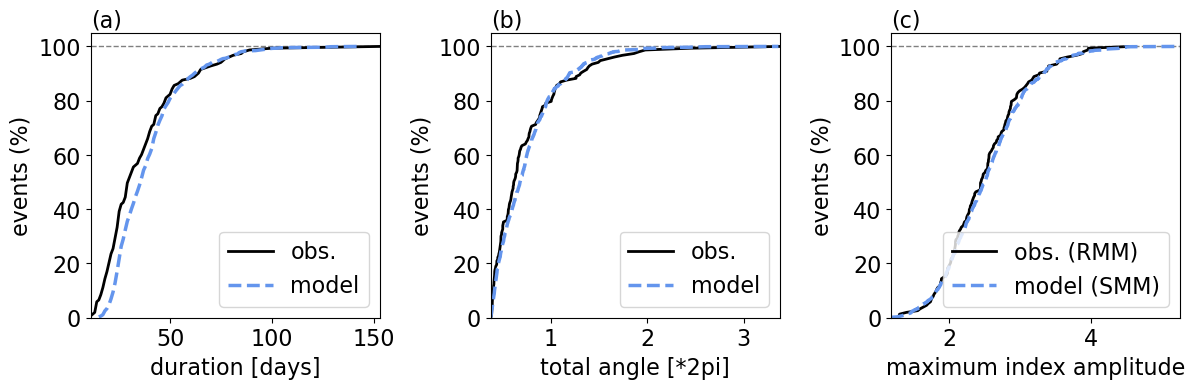

In [18]:
# plot statistics
fig, axs = subplots(1,3, figsize = (12,4))

#######################################################################################################
axs[1].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)


duration_sorted = sort(duration_ref);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_ref)[1])
end

axs[1].plot(duration_sorted, data*100, color="black", alpha=1, linewidth=2, label = "obs.")

duration_sorted = sort(durations);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations)[1])
end

axs[1].plot(duration_sorted, data*100, linestyle = "--", color="cornflowerblue", alpha=1, linewidth=2.5, label = "model")


axs[1].set_xlabel("duration [days]", fontsize = 16)
axs[1].set_ylabel("events (%)", fontsize = 16)
axs[1].tick_params(axis="both", labelsize=16)

min_d = minimum([durations; duration_ref])
max_d = maximum([durations; duration_ref])

axs[1].set_xlim([min_d,max_d])
axs[1].set_ylim([0,105])
axs[1].legend(fontsize=16, loc = "lower right")


########################################################################################################

axs[2].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)


total_angle_sorted = sort(angle_ref./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angle_ref)[1])
end

axs[2].plot(total_angle_sorted, data*100, color="black", alpha=1, linewidth=2, label = "obs.")

total_angle_sorted = sort(angles./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles)[1])
end

axs[2].plot(total_angle_sorted, data*100, linestyle = "--", color="cornflowerblue", alpha=1, linewidth=2.5, label = "model")


axs[2].set_xlabel("total angle [*2pi]", fontsize = 16)
axs[2].set_ylabel("events (%)", fontsize = 16)
axs[2].tick_params(axis="both", labelsize=16)

min_a = minimum([angles; angle_ref])
max_a = maximum([angles; angle_ref])

axs[2].set_xlim([min_a./2/pi, max_a./2/pi])
axs[2].set_ylim([0,105])
axs[2].legend(fontsize=16, loc = "lower right")


########################################################################################################

axs[3].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

max_amplitude_sorted = sort(maxRMM_ref);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMM_ref)[1])
end
#data = [data]

axs[3].plot(max_amplitude_sorted, data*100, color="black", alpha=1, linewidth=2, label = "obs. (RMM)")

RMM_sim_sorted = sort(maxRMMs);
data = [];
for m in RMM_sim_sorted
    cdf = sum(RMM_sim_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs)[1])
end

axs[3].plot(RMM_sim_sorted, data*100, linestyle = "--", color="cornflowerblue", alpha=1, linewidth=2.5, label = "model (SMM)")


axs[3].set_xlabel("maximum index amplitude", fontsize = 16)
axs[3].set_ylabel("events (%)", fontsize = 16)
axs[3].tick_params(axis="both", labelsize=16)

min_r = minimum([maxRMMs; maxRMM_ref])
max_r = maximum([maxRMMs; maxRMM_ref])

axs[3].set_xlim([min_r,max_r])
axs[3].set_ylim([0,105])
axs[3].legend(fontsize=16, loc = "lower right")

########################################################################################################

axs[1].text(min_d, 107, "(a)", fontsize=16)
axs[2].text(min_a/2/pi, 107, "(b)", fontsize=16)
axs[3].text(min_r, 107, "(c)", fontsize=16)


########################################################################################################
tight_layout()
savefig("figures/comparison_obs_sim.png", dpi = 600, bbox_inches="tight", transparent = true)

# Initial and final phase

In [42]:
# number of (primary) events starting in each phase
starting_phases_ref = [19.0, 28.0, 20.0, 14.0, 17.0, 21.0, 18.0, 16.0]; # reference from observation
starting_phases = zeros(8)
for nr in 1:NUM_REPEAT
    sps = events.starting_phase(seqs[nr], phase[nr,:]);
    starting_phases = starting_phases .+ sps;
end

# number of events ending in each phase
ending_phases_ref = [23.0, 19.0, 12.0, 16.0, 16.0, 20.0, 18.0, 29.0]; # reference from observation
ending_phases = zeros(8)
for nr in 1:NUM_REPEAT
    eps = events.ending_phase(seqs[nr], phase[nr,:]);
    ending_phases = ending_phases .+ eps;
end

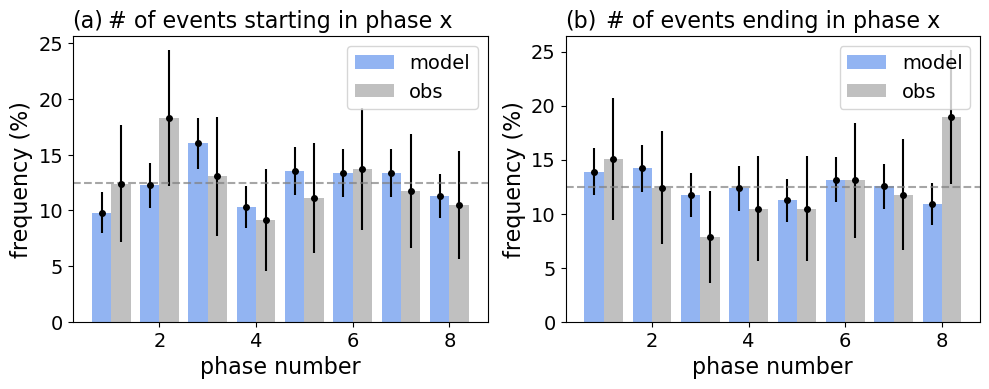

In [45]:
fig, axs = subplots(1,2, figsize = (10,4))


equal_likelyhood = 1/8*100;
width = 0.4


########################################################################################################
total = sum(starting_phases);
total_ref = sum(starting_phases_ref);

error_bars = zeros(8);
for i =1:8
    phat = starting_phases[i]/total
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars[i] =  z*sqrt(phat*(1-phat)/total)
end

error_bars_ref = zeros(8);
for i =1:8
    phat = starting_phases_ref[i]/total_ref
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars_ref[i] =  z*sqrt(phat*(1-phat)/total_ref)
end


axs[1].bar(0.8:7.8, starting_phases/total*100, width=width, color = "cornflowerblue", alpha = 0.7, label = "model")
axs[1].errorbar(0.8:7.8, starting_phases/total*100, yerr=error_bars*100, fmt="o", color="k", ms = 4)

axs[1].bar(1.2:8.2, starting_phases_ref/total_ref*100, width=width, color = "silver", label = "obs")
axs[1].errorbar(1.2:8.2, starting_phases_ref/total_ref*100, yerr=error_bars_ref*100, fmt="o", color="k", ms = 4)


axs[1].axhline(y = equal_likelyhood, linestyle = "--", color = "grey", alpha = 0.7)
axs[1].set_ylabel("frequency (%)", fontsize = 16)
axs[1].set_xlabel("phase number", fontsize = 16)
axs[1].set_title("# of events starting in phase x", fontsize = 16)
axs[1].legend(fontsize=14)

########################################################################################################

# number of events ending in each phase
total = sum(ending_phases)
total_ref = sum(ending_phases_ref);


error_bars = zeros(8);
for i =1:8
    phat = ending_phases[i]/total
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars[i] =  z*sqrt(phat*(1-phat)/total)
end

error_bars_ref = zeros(8);
for i =1:8
    phat = ending_phases_ref[i]/total_ref
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars_ref[i] =  z*sqrt(phat*(1-phat)/total_ref)
end


axs[2].bar(0.8:7.8, ending_phases/total*100, width=width, color = "cornflowerblue", alpha = 0.7, label = "model")
axs[2].errorbar(0.8:7.8, ending_phases/total*100, yerr=error_bars*100, fmt="o", color="k", ms = 4)
axs[2].bar(1.2:8.2, ending_phases_ref/total_ref*100, width=width, color = "silver", label = "obs")
axs[2].errorbar(1.2:8.2, ending_phases_ref/total_ref*100, yerr=error_bars_ref*100, fmt="o", color="k", ms = 4)

axs[2].axhline(y = equal_likelyhood, linestyle = "--", color = "grey", alpha = 0.7)
axs[2].set_ylabel("frequency (%)", fontsize = 16)
axs[2].set_xlabel("phase number", fontsize = 16)
axs[2].set_title("# of events ending in phase x", fontsize = 16)

axs[2].legend(fontsize=14)
########################################################################################################
max_s = axs[1].get_ylim()[2]
max_e = axs[2].get_ylim()[2]

axs[1].text(width/2, max_s + 3/100*max_s, "(a)", fontsize=16)
axs[2].text(width/2, max_e + 3/100*max_e, "(b)", fontsize=16)

axs[1].tick_params(axis="both", labelsize=14)
axs[2].tick_params(axis="both", labelsize=14)

########################################################################################################
tight_layout()
savefig("figures/starting_ending_phases.png", dpi = 600, bbox_inches="tight", transparent = true)


# ENSO comparison

In [33]:
# compute number of events occuring in each phase of ENSO

seqN = [];
seqEN = [];
seqLN = [];
frac = [];
for nr in 1:NUM_REPEAT
    seqN_, seqEN_, seqLN_, frac_ = events.div_seq_ENSO_phases(seqs[nr], years_tracked, months_tracked_, ENSO_ym, ENSO_phases);
    push!(seqN, seqN_);
    push!(seqEN, seqEN_);
    push!(seqLN, seqLN_);
    push!(frac, frac_);
end

In [34]:


totN = zeros(NUM_REPEAT);
totEN = zeros(NUM_REPEAT);
totLN = zeros(NUM_REPEAT);
for nr in 1:NUM_REPEAT
    totN_ =0;
    totEN_ =0;
    totLN_ =0;
    for i in 1:size(seqN[nr])[1]
        totN_ += seqN[nr][i,2]-seqN[nr][i,1]+1
    end
    for i in 1:size(seqEN[nr])[1]
        totEN_ += seqEN[nr][i,2]-seqEN[nr][i,1]+1
    end
    for i in 1:size(seqLN[nr])[1]
        totLN_ += seqLN[nr][i,2]-seqLN[nr][i,1]+1
    end
    totN[nr]=totN_;
    totEN[nr]=totEN_;
    totLN[nr]=totLN_;
end

sum_ = totN .+ totEN .+ totLN;

numbers_EN = totEN./sum_;
numbers_LN = totLN./sum_;
numbers_N = totN./sum_;

println("Average percentage of active MJO days occuring during El Niño :", mean(numbers_EN).*100, " +/- ", std(numbers_EN).*100/sqrt(NUM_REPEAT))
println("Average percentage of active MJO days occuring during La Niña :", mean(numbers_LN).*100, " +/- ", std(numbers_LN).*100/sqrt(NUM_REPEAT))
println("Average percentage of active MJO days occuring during Neutral :", mean(numbers_N).*100, " +/- ", std(numbers_N).*100/sqrt(NUM_REPEAT))




Average percentage of active MJO days occuring during El Niño :20.261006024903043 +/- 1.3173451488897914
Average percentage of active MJO days occuring during La Niña :23.915927323603107 +/- 1.2230700018755043
Average percentage of active MJO days occuring during Neutral :55.82306665149386 +/- 1.840021364223617


### Duration 

In [35]:
durations_N = [];
mean_durations_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqN[nr]);
    append!(durations_N, durations_nr);
    mean_durations_N[nr] = mean(durations_nr);
end

mean_duration_N = mean(mean_durations_N);
std_duration_N = std(mean_durations_N);

println("Mean duration for Neutral events :", mean_duration_N, " +/- ", std_duration_N/sqrt(NUM_REPEAT))

# El Niño
durations_EN = [];
mean_durations_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqEN[nr]);
    append!(durations_EN, durations_nr);
    mean_durations_EN[nr] = mean(durations_nr);
end

mean_duration_EN = mean(mean_durations_EN);
std_duration_EN = std(mean_durations_EN);

println("Mean duration for El Niño events :", mean_duration_EN, " +/- ", std_duration_EN/sqrt(NUM_REPEAT))


# La Niña
durations_LN = [];
mean_durations_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqLN[nr]);
    append!(durations_LN, durations_nr);
    mean_durations_LN[nr] = mean(durations_nr);
end

mean_duration_LN = mean(mean_durations_LN);
std_duration_LN = std(mean_durations_LN);

println("Mean duration for La Niña events :", mean_duration_LN, " +/- ", std_duration_LN/sqrt(NUM_REPEAT))


Mean duration for Neutral events :39.59816823851911 +/- 0.5867708356016582
Mean duration for El Niño events :38.32813500769383 +/- 1.2748275657889894
Mean duration for La Niña events :40.66134474257539 +/- 1.7571700014219223


In [36]:
# Neutral
max_durations_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqN[nr]);
    max_durations_N[nr] = maximum(durations_nr);
end

max_duration_N = mean(max_durations_N);
std_duration_N = std(max_durations_N);

println("Maximum duration for Neutral events :", max_duration_N, " +/- ", std_duration_N/sqrt(NUM_REPEAT))

# El Niño
max_durations_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqEN[nr]);
    max_durations_EN[nr] = maximum(durations_nr);
end

max_duration_EN = mean(max_durations_EN);
std_duration_EN = std(max_durations_EN);

println("Maximum duration for El Niño events :", max_duration_EN, " +/- ", std_duration_EN/sqrt(NUM_REPEAT))


# La Niña
max_durations_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqLN[nr]);
    max_durations_LN[nr] = maximum(durations_nr);
end

max_duration_LN = mean(max_durations_LN);
std_duration_LN = std(max_durations_LN);

println("Maximum duration for La Niña events :", max_duration_LN, " +/- ", std_duration_LN/sqrt(NUM_REPEAT))

Maximum duration for Neutral events :90.66666666666667 +/- 5.5614888950854455
Maximum duration for El Niño events :73.4 +/- 4.414046842049767
Maximum duration for La Niña events :80.93333333333334 +/- 6.1802039314994


In [37]:
println("Number of MJO events during Neutral ENSO: ", length(durations_N))
println("Number of MJO events during El Niño: ", length(durations_EN))
println("Number of MJO events during La Niña: ", length(durations_LN))

Number of MJO events during Neutral ENSO: 547
Number of MJO events during El Niño: 205
Number of MJO events during La Niña: 228


### Angle

In [38]:
# Neutral

angles_N = [];

mean_angles_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqN[nr], phase[nr,:]);
    append!(angles_N, angles_nr);
    mean_angles_N[nr] = mean(angles_nr);
end

mean_angle_N = mean(mean_angles_N);
std_angle_N = std(mean_angles_N ./2 ./pi);

println("Mean angle for Neutral events:", mean_angle_N/2/pi, " +/- ", std_angle_N/sqrt(NUM_REPEAT), " * 2pi.")


# El Niño
angles_EN = [];

mean_angles_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqEN[nr], phase[nr,:]);
    append!(angles_EN, angles_nr);
    mean_angles_EN[nr] = mean(angles_nr);
end

mean_angle_EN = mean(mean_angles_EN);
std_angle_EN = std(mean_angles_EN ./2 ./pi);

println("Mean angle for El Niño events:", mean_angle_EN/2/pi, " +/- ", std_angle_EN/sqrt(NUM_REPEAT), " * 2pi.")


# La Niña
angles_LN = [];

mean_angles_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqLN[nr], phase[nr,:]);
    append!(angles_LN, angles_nr);
    mean_angles_LN[nr] = mean(angles_nr);
end

mean_angle_LN = mean(mean_angles_LN);
std_angle_LN = std(mean_angles_LN ./2 ./pi);

println("Mean angle for La Niña:", mean_angle_LN/2/pi, " +/- ", std_angle_LN/sqrt(NUM_REPEAT), " * 2pi.")


Mean angle for Neutral events:0.7488527589805106 +/- 0.011661569958208395 * 2pi.
Mean angle for El Niño events:0.7307390232306089 +/- 0.023910615844794005 * 2pi.
Mean angle for La Niña:0.7921594494159342 +/- 0.03621275342612607 * 2pi.


In [39]:
# Neutral


max_angles_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqN[nr], phase[nr,:]);
    max_angles_N[nr] = maximum(angles_nr);
end

max_angle_N = mean(max_angles_N);
std_angle_N = std(max_angles_N ./2 ./pi);

println("Maximum angle for Neutral events:", max_angle_N/2/pi, " +/- ", std_angle_N/sqrt(NUM_REPEAT), " * 2pi.")


# El Niño

max_angles_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqEN[nr], phase[nr,:]);
    max_angles_EN[nr] = maximum(angles_nr);
end

max_angle_EN = mean(max_angles_EN);
std_angle_EN = std(max_angles_EN ./2 ./pi);

println("Maximum angle for El Niño events:", max_angle_EN/2/pi, " +/- ", std_angle_EN/sqrt(NUM_REPEAT), " * 2pi.")


# La Niña

max_angles_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqLN[nr], phase[nr,:]);
    max_angles_LN[nr] = maximum(angles_nr);
end

max_angle_LN = mean(max_angles_LN);
std_angle_LN = std(max_angles_LN ./2 ./pi);

println("Maximum angle for La Niña:", max_angle_LN/2/pi, " +/- ", std_angle_LN/sqrt(NUM_REPEAT), " * 2pi.")


Maximum angle for Neutral events:1.7492267502191687 +/- 0.14890378378208122 * 2pi.
Maximum angle for El Niño events:1.4439250471262912 +/- 0.09909173576064352 * 2pi.
Maximum angle for La Niña:1.553525441193711 +/- 0.13091590083810584 * 2pi.


### Max RMM

In [40]:
# Neutral
maxRMMs_N = [];
mean_maxRMMs_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqN[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs_N, maxRMMs_nr);
    mean_maxRMMs_N[nr] = mean(maxRMMs_nr);
end

mean_maxRMM_N = mean(mean_maxRMMs_N);
std_maxRMM_N = std(mean_maxRMMs_N);

println("Mean of the maximum values of RMM for Neutral events:", mean_maxRMM_N, " +/- ", std_maxRMM_N/sqrt(NUM_REPEAT))

# El Niño
maxRMMs_EN = [];
mean_maxRMMs_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqEN[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs_EN, maxRMMs_nr);
    mean_maxRMMs_EN[nr] = mean(maxRMMs_nr);
end

mean_maxRMM_EN = mean(mean_maxRMMs_EN);
std_maxRMM_EN = std(mean_maxRMMs_EN);

println("Mean of the maximum values of RMM for El Niño events:", mean_maxRMM_EN, " +/- ", std_maxRMM_EN/sqrt(NUM_REPEAT))

# La Niña
maxRMMs_LN = [];
mean_maxRMMs_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqLN[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs_LN, maxRMMs_nr);
    mean_maxRMMs_LN[nr] = mean(maxRMMs_nr);
end

mean_maxRMM_LN = mean(mean_maxRMMs_LN);
std_maxRMM_LN = std(mean_maxRMMs_LN);

println("Mean of the maximum values of RMM for La Niña events:", mean_maxRMM_LN, " +/- ", std_maxRMM_LN/sqrt(NUM_REPEAT))

Mean of the maximum values of RMM for Neutral events:2.534881951262609 +/- 0.02466479355932954
Mean of the maximum values of RMM for El Niño events:2.5718021507103006 +/- 0.03582995805465723
Mean of the maximum values of RMM for La Niña events:2.5054027351704646 +/- 0.045877536451684034


In [41]:
# Neutral
max_maxRMMs_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqN[nr], amplitude[nr,:], phase[nr,:]);
    max_maxRMMs_N[nr] = maximum(maxRMMs_nr);
end

max_maxRMM_N = mean(max_maxRMMs_N);
std_maxRMM_N = std(max_maxRMMs_N);

println("Maximum of the maximum values of RMM for Neutral events:", max_maxRMM_N, " +/- ", std_maxRMM_N/sqrt(NUM_REPEAT))

# El Niño
max_maxRMMs_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqEN[nr], amplitude[nr,:], phase[nr,:]);
    max_maxRMMs_EN[nr] = maximum(maxRMMs_nr);
end

max_maxRMM_EN = mean(max_maxRMMs_EN);
std_maxRMM_EN = std(max_maxRMMs_EN);

println("Maximum of the maximum values of RMM for El Niño events:", max_maxRMM_EN, " +/- ", std_maxRMM_EN/sqrt(NUM_REPEAT))

# La Niña
max_maxRMMs_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqLN[nr], amplitude[nr,:], phase[nr,:]);
    max_maxRMMs_LN[nr] = maximum(maxRMMs_nr);
end

max_maxRMM_LN = mean(max_maxRMMs_LN);
std_maxRMM_LN = std(max_maxRMMs_LN);

println("Maximum of the maximum values of RMM for La Niña events:", max_maxRMM_LN, " +/- ", std_maxRMM_LN/sqrt(NUM_REPEAT))

Maximum of the maximum values of RMM for Neutral events:3.9631446389401703 +/- 0.08502606119800514
Maximum of the maximum values of RMM for El Niño events:3.7146243795977982 +/- 0.11176926226891046
Maximum of the maximum values of RMM for La Niña events:3.818973502681025 +/- 0.13718929400389435


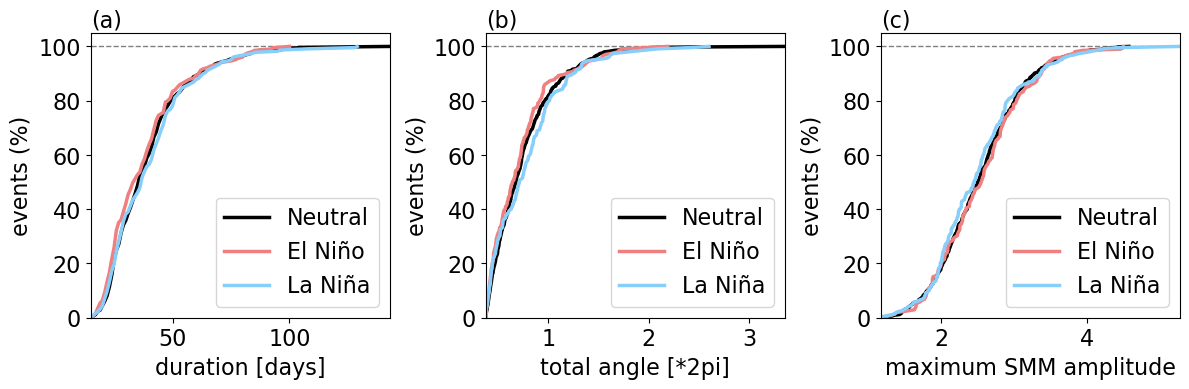

In [43]:
fig, axs = subplots(1,3, figsize = (12,4))

axs[1].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

duration_sorted = sort(durations_N);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations_N)[1])
end

axs[1].plot(duration_sorted, data*100, color="black", alpha=1, linewidth=2.5, label = "Neutral")

duration_sorted = sort(durations_EN);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations_EN)[1])
end

axs[1].plot(duration_sorted, data*100, color="lightcoral", alpha=1, linewidth=2.5, label = "El Niño")

duration_sorted = sort(durations_LN);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations_LN)[1])
end

axs[1].plot(duration_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2.5, label = "La Niña")


axs[1].set_xlabel("duration [days]", fontsize = 16)
axs[1].set_ylabel("events (%)", fontsize = 16)
axs[1].tick_params(axis="both", labelsize=16)

min_d = minimum([durations_LN; durations_EN; durations_N])
max_d = maximum([durations_LN; durations_EN; durations_N])

axs[1].set_xlim([min_d, max_d])
axs[1].set_ylim([0,105])
axs[1].legend(fontsize=16, loc = "lower right")

########################################################################################################

axs[2].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

total_angle_sorted = sort(angles_N./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles_N)[1])
end
axs[2].plot(total_angle_sorted, data*100, color="black", alpha=1, linewidth=2.5, label = "Neutral")

total_angle_sorted = sort(angles_EN./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles_EN)[1])
end
axs[2].plot(total_angle_sorted, data*100, color="lightcoral", alpha=1, linewidth=2.5, label = "El Niño")

total_angle_sorted = sort(angles_LN./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles_LN)[1])
end
axs[2].plot(total_angle_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2.5, label = "La Niña")


axs[2].set_xlabel("total angle [*2pi]", fontsize = 16)
axs[2].set_ylabel("events (%)", fontsize = 16)
axs[2].tick_params(axis="both", labelsize=16)

min_a = minimum([angles_LN; angles_EN; angles_N])
max_a = maximum([angles_LN; angles_EN; angles_N])

axs[2].set_xlim([min_a./2/pi, max_a./2/pi])
axs[2].set_ylim([0,105])
axs[2].legend(fontsize=16, loc = "lower right")
########################################################################################################

axs[3].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

max_amplitude_sorted = sort(maxRMMs_N);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs_N)[1])
end
axs[3].plot(max_amplitude_sorted, data*100, color="black", alpha=1, linewidth=2.5, label = "Neutral")

max_amplitude_sorted = sort(maxRMMs_EN);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs_EN)[1])
end
axs[3].plot(max_amplitude_sorted, data*100, color="lightcoral", alpha=1, linewidth=2.5, label = "El Niño")

max_amplitude_sorted = sort(maxRMMs_LN);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs_LN)[1])
end
axs[3].plot(max_amplitude_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2.5, label = "La Niña")


axs[3].set_xlabel("maximum SMM amplitude", fontsize = 16)
axs[3].set_ylabel("events (%)", fontsize = 16)
axs[3].tick_params(axis="both", labelsize=16)

min_r = minimum([maxRMMs_LN; maxRMMs_EN; maxRMMs_N])
max_r = maximum([maxRMMs_LN; maxRMMs_EN; maxRMMs_N])


axs[3].set_xlim([min_r, max_r])
axs[3].set_ylim([0,105])
axs[3].legend(fontsize=16, loc = "lower right")



########################################################################################################

axs[1].text(min_d, 107, "(a)", fontsize=16)
axs[2].text(min_a/2/pi, 107, "(b)", fontsize=16)
axs[3].text(min_r, 107, "(c)", fontsize=16)


########################################################################################################
tight_layout()
savefig("figures/ENSO_sim.png", dpi = 300, bbox_inches="tight", transparent = true)



